In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import sqlite3
import pandas
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back),:]
		dataX.append(a)
		dataY.append(dataset[i + look_back, :])
	return np.array(dataX), np.array(dataY)

# fix random seed for reproducibility
tf.random.set_seed(0)

conn = sqlite3.connect('db.sqlite3')
data = conn.execute("""
with data_time as (
select sum(value) as attendances, commune_id, date(data.year || '-' || (
    case data.cohort
        when 'Enero' then '01'
        when 'Febrero' then '02'
        when 'Marzo' then '03'
        when 'Abril' then '04'
        when 'Mayo' then '05'
        when 'Junio' then '06'
        when 'Julio' then '07'
        when 'Agosto' then '08'
        when 'Septiembre' then '09'
        when 'Octubre' then '10'
        when 'Noviembre' then '11'
        when 'Diciembre' then '12'
        else 1
    end) || '-01') as date
from data
join report on data.report_id = report.id
where report.description = 'Ingresos Programa de Salud Mental por mes y año'
group by date, commune_id
),
contaminant_time as (
select avg(concentration) as concentration, commune_id, date(datetime, 'unixepoch', 'start of month') as date
from contaminant
where contaminant.contaminant = 'SO2'
group by date, commune_id
)
select commune.name, contaminant_time.concentration as so2, data_time.date, attendances * 10000 / commune.population from data_time
join contaminant_time on data_time.date = contaminant_time.date and data_time.commune_id = contaminant_time.commune_id
join commune on data_time.commune_id = commune.id
""").fetchall()

# drop unixtimestamp
data = pandas.DataFrame(data, columns=['commune', 'so2', 'date', 'attendances'])
data.index = pandas.to_datetime(data['date'])
data = data.drop(columns=['date'])

scaler = StandardScaler()
data[['so2']] = scaler.fit_transform(data[['so2']])
data[['attendances']] = scaler.fit_transform(data[['attendances']])

data

2025-10-19 02:19:27.012696: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-19 02:19:27.040716: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-19 02:19:27.537700: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


,commune,so2,attendances
date,,,
2018-01-01,LA CISTERNA,0.318082,0.301024
2018-01-01,PENALOLEN,-1.227433,0.614815
2018-01-01,PUENTE ALTO,0.839011,0.824010
2018-01-01,TALAGANTE,-1.602993,-0.849545
2018-02-01,LA CISTERNA,-1.384115,-0.640351
...,...,...,...
2024-04-01,LA CISTERNA,1.280945,1.137801
2024-04-01,PENALOLEN,0.998143,0.510218
2024-05-01,PENALOLEN,1.432024,0.614815


/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


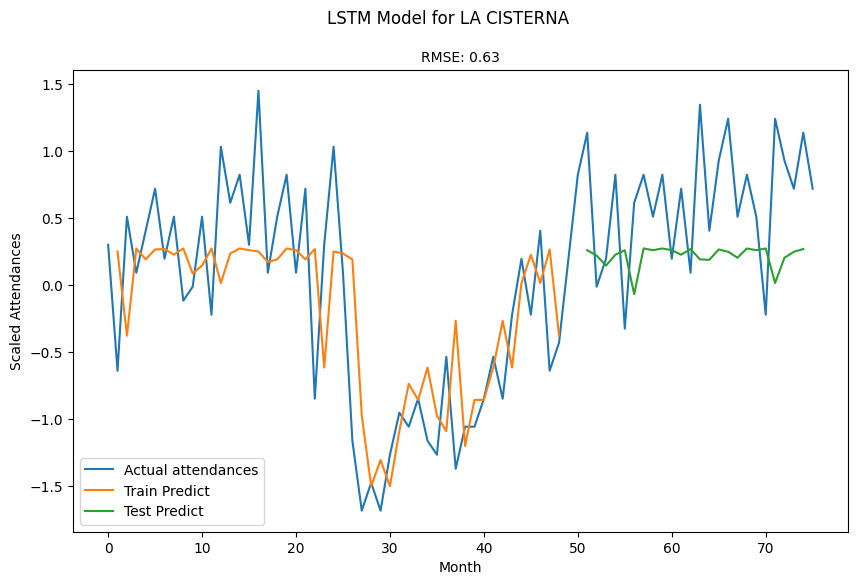

/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Train Score: 0.50 RMSE
Test Score: 0.86 RMSE


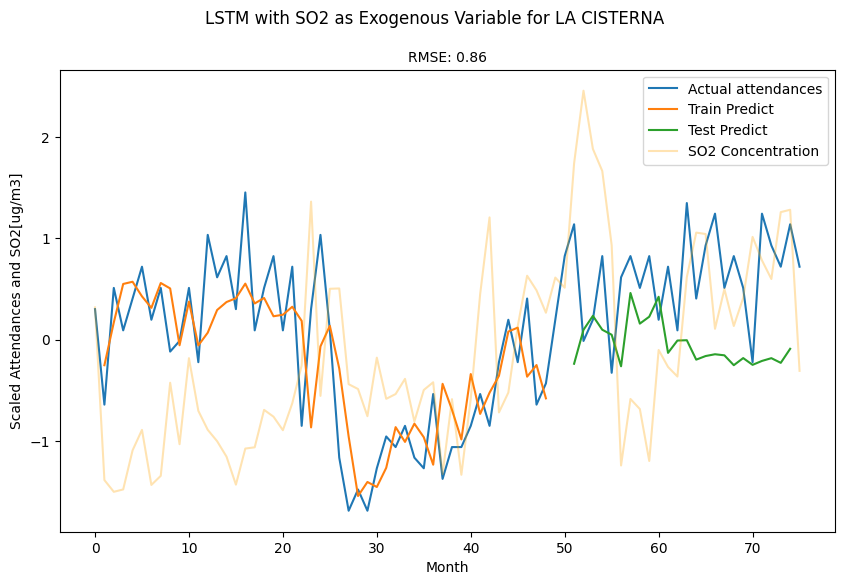

/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


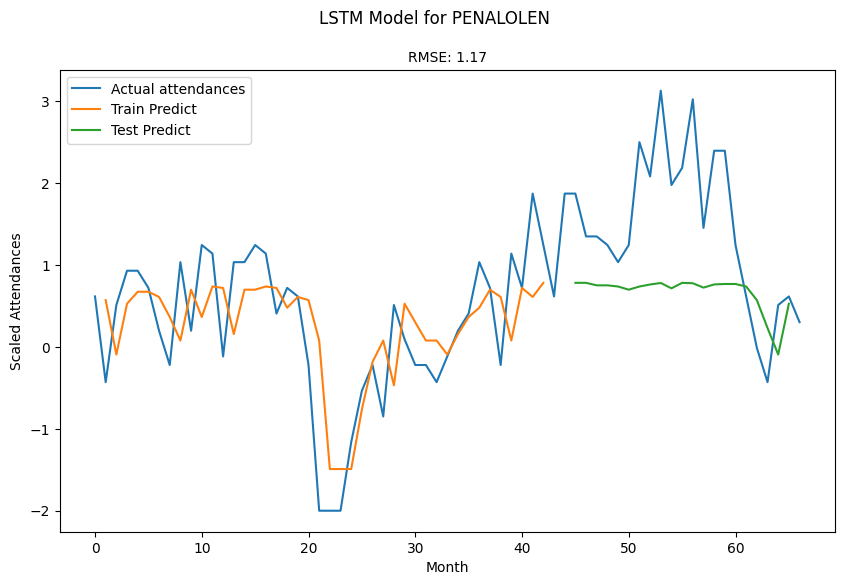

/home/espi/Developer/mental-health-exploration/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [7]:
for commune in data["commune"].unique():
    dataset = data[data["commune"] == commune][['attendances']].to_numpy().astype('float32')

    train_size = int(len(dataset) * 0.67)
    train = dataset[0:train_size,:]
    test = dataset[train_size:len(dataset),:]

    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[2]))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
    testScore = np.sqrt(mean_squared_error(testY, testPredict))

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.figure(figsize=(10,6))
    plt.suptitle('LSTM Model for ' + commune)
    plt.title(f'RMSE: {testScore:<.2f}', fontsize=10)
    plt.xlabel('Month')
    plt.ylabel('Scaled Attendances')
    plt.plot(dataset[:,0], label='Actual attendances')
    plt.plot(trainPredictPlot[:,0], label='Train Predict')
    plt.plot(testPredictPlot[:,0], label='Test Predict')
    plt.legend()
    plt.savefig(f'img/lstm_{commune}.png')
    plt.show()


    dataset = data[data["commune"] == commune][['attendances', 'so2']].to_numpy().astype('float32')

    train_size = int(len(dataset) * 0.67)
    train = dataset[0:train_size,:]
    test  = dataset[train_size:len(dataset),:]

    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # discard so2 from output
    trainY = trainY[:,0]
    testY = testY[:,0]

    # ValueError: cannot reshape array of size 84 into shape (42,1,1)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 2, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 2, testX.shape[1]))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(2, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = np.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))

    # plot
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    # plot baseline and predictions
    plt.figure(figsize=(10,6))
    plt.suptitle('LSTM with SO2 as Exogenous Variable for ' + commune)
    plt.title(f'RMSE: {testScore:<.2f}', fontsize=10)
    plt.xlabel('Month')
    plt.ylabel('Scaled Attendances and SO2[ug/m3]')
    plt.plot(dataset[:,0], label='Actual attendances')
    plt.plot(trainPredictPlot[:,0], label='Train Predict')
    plt.plot(testPredictPlot[:,0], label='Test Predict')
    # plot concentration as well
    plt.plot(data[data["commune"] == commune]['so2'].to_numpy(), label='SO2 Concentration', color='orange', alpha=0.3)
    plt.legend()
    plt.savefig(f'img/lstm_{commune}_so2.png')
    plt.show()
